---
# **Import the required libraries**


In [ ]:
import numpy as np                                                      
import pandas as pd                                                    
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
import pickle
import matplotlib.pyplot as plt                                        
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

# **Read data & Preprocessing that needs to be carried out**



In [ ]:
# Now, we add our dataset here. To do that we need to upload the csv file on google colab
from google.colab import files
uploaded = files.upload()

Saving attractions_cluster.csv to attractions_cluster (3).csv


In [ ]:
# read data
attractions_df = pd.read_csv("attractions_cluster.csv",index_col=0) 
attractions_df.head()

,location_name,location_type,ratings,no. of rating,provience,user_id
location_id,,,,,,
0,Ripley's Aquarium of Canada,Aquariums,4.5,"20,326",ontario,1
1,Mount Royal Park,Parks,3.0,"10,493",quebec,1
2,Stanley Park,Parks,4.5,"28,722",BC,1
3,Niagara Falls Canada,Points of Interest & Landmarks Waterfalls,1.0,"31,476",ontario,2
4,Old Quebec,Neighbourhoods Historic Walking Areas,5.0,"13,360",quebec,2



**The code Structure**

The diagram below clearly shows the process flow and steps to build content based recommender system using Kmeans clustering

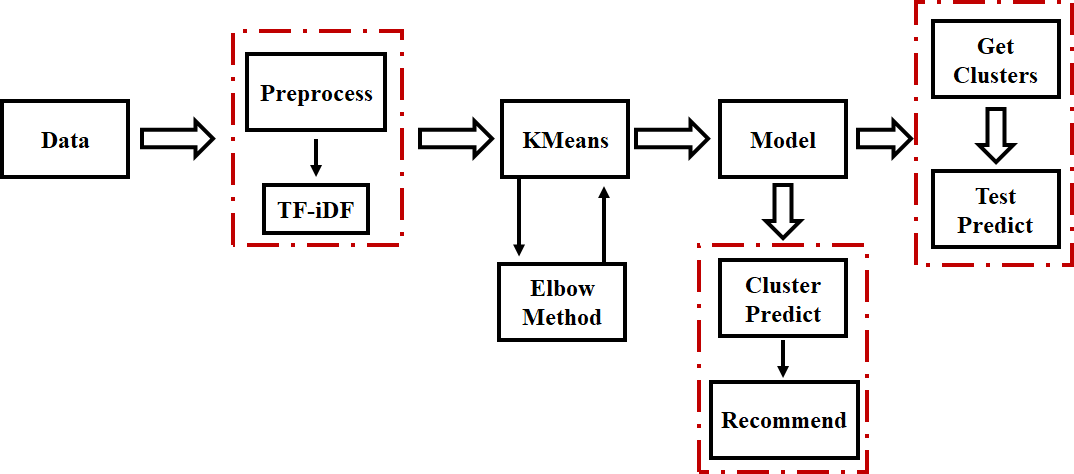

**Preprocessing Steps**

Some steps are used to preprocess the text such as:
- removing stopwords
- remove all characters except numbers and alphabets
- reomve NaN values if available
- combine columns containing attraction name, attraction type, and the province.

In [ ]:
# drop rows with NaN values for any column, specifically
attractions_df = attractions_df.dropna(how='any')
# Pre-processing step: Removal of '-'
attractions_df.replace({"-": " "}, regex=True)
# Combine three columns namely: location_name, location_type, and provience
# As all of them reveal some information about the attraction
comb_frame = attractions_df.location_name.str.cat(" "+attractions_df.location_type.str.cat(" "+attractions_df.provience))
# remove all characters except numbers and alphabets
comb_frame=comb_frame.replace({"[^A-Za-z0-9 ]+": ""}, regex=True)

In [ ]:
comb_frame.head()

location_id
0         Ripleys Aquarium of Canada Aquariums ontario
1                        Mount Royal Park Parks quebec
2                                Stanley Park Parks BC
3    Niagara Falls Canada Points of Interest  Landm...
4    Old Quebec Neighbourhoods   Historic Walking A...
Name: location_name, dtype: object

**TF-iDF Vectorization**

After carrying out basic cleaning steps for the above data, ‘comb_frame’ contains all the necessary word descriptions related to a attraction. After, that let’s move onto to vectorization of this text and train our model.

In [ ]:
# Create word vectors from combined frames 
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(comb_frame)

**Elbow Method Optimzation**


Elbow method is used with either sum of squared error(sse) or within cluster sum of errors(wcss). Here, we used wcss to find the optimal number of clusters.

In [ ]:
# Perform Elbow method
wcss = {}
# Looping over multiple values of k from 1 to 35
for k in range(1, 25):
    kmeans = KMeans(n_clusters=k, init='k-means++').fit(X)
    comb_frame["clusters"] = kmeans.labels_
    wcss[k] = kmeans.inertia_

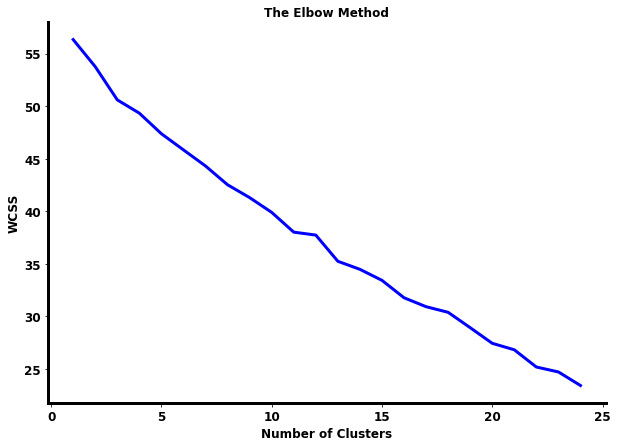

In [ ]:
# Plotting the curve with 'k'-value vs SSE
plt.figure(figsize=(10, 7))
plt.plot(list(wcss.keys()), list(wcss.values()),'b-',lw=3.0)
plt.title('The Elbow Method',fontsize = 12,fontweight='bold')
#plt.xlabel("Number of cluster")
#plt.ylabel("SSE")
plt.xlabel('Number of Clusters',fontsize = 12,fontweight='bold')
plt.ylabel('WCSS',fontsize = 12,fontweight='bold')
import matplotlib as mpl
mpl.rcParams["axes.spines.right"] = False; mpl.rcParams["axes.spines.top"] = False
from pylab import *
rc('axes', linewidth=3)
fontsize = 12
ax = gca()
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
    tick.label1.set_fontweight('bold')
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
    tick.label1.set_fontweight('bold')
plt.show()
# Save the Plot in current directory
#plt.savefig('elbow_method.png')

Since we do not have a clear elobw point, we will train the model at diferent flexiom points and calculate and visulaize the silhouette score at different number of clusters and choose the highest silhouette score.



In [ ]:
# Function to reduce the dimentions of our data usin PCA
def pca(vector):
  from sklearn.decomposition import PCA
  pca_trans = PCA(n_components=2).fit_transform(vector)
  PCA_components = pd.DataFrame(data = pca_trans)
  return pca_trans,PCA_components

In [ ]:
# Function to visulaize and calculate silhouette
def silhouette_vis(PCA_components):
  from sklearn.metrics import silhouette_score,silhouette_samples
  from matplotlib import cm
  for clusters in [10,11,14,16]:
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    clusterer = KMeans(n_clusters=clusters,init='k-means++')
    cluster_labels = clusterer.fit_predict(PCA_components)
    silhouette_avg = silhouette_score(PCA_components, cluster_labels)
    print('The average silhouette score = {} for {} clusters'.format(silhouette_avg,clusters))

    sample_silhouette_values = silhouette_samples(PCA_components, cluster_labels)

    y_lower = 10
    for i in range(clusters):
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10  

    ax1.set_title("Silhouette Visualization",fontsize = 12,fontweight='bold')
    ax1.set_xlabel("Silhouette Coefficient",fontsize = 12,fontweight='bold')
    ax1.set_ylabel("Cluster Label",fontsize = 12,fontweight='bold')

    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([]) 
    colors = cm.nipy_spectral(cluster_labels.astype(float) / clusters)
    ax2.scatter(PCA_components.iloc[:, 0], PCA_components.iloc[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    centers = clusterer.cluster_centers_
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("Clusters Visualization",fontsize = 12,fontweight='bold')
    ax2.set_xlabel("PC1",fontsize = 12,fontweight='bold')
    ax2.set_ylabel("PC2",fontsize = 12,fontweight='bold')
    plt.suptitle(("Silhouette analysis for KMeans with clusters = %d" % clusters),fontsize=14, fontweight='bold')
    plt.show()

Silhouette

A measure of how similar an object is to its own cluster (cohesion) compared to other clusters (separation).
Range = [-1, 1];

The higher value, the better avg match is within the cluster.

The average silhouette score = 0.48426835799086 for 10 clusters


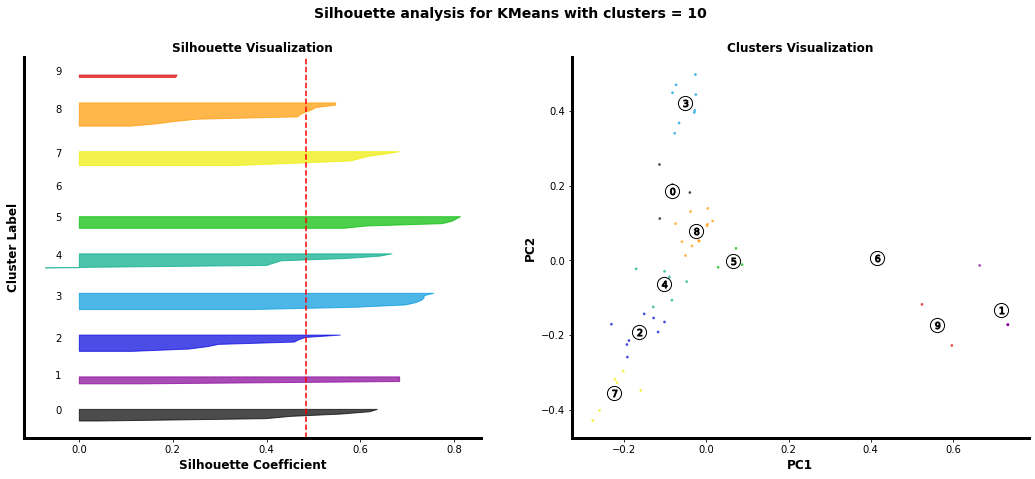

The average silhouette score = 0.5053561795180114 for 11 clusters


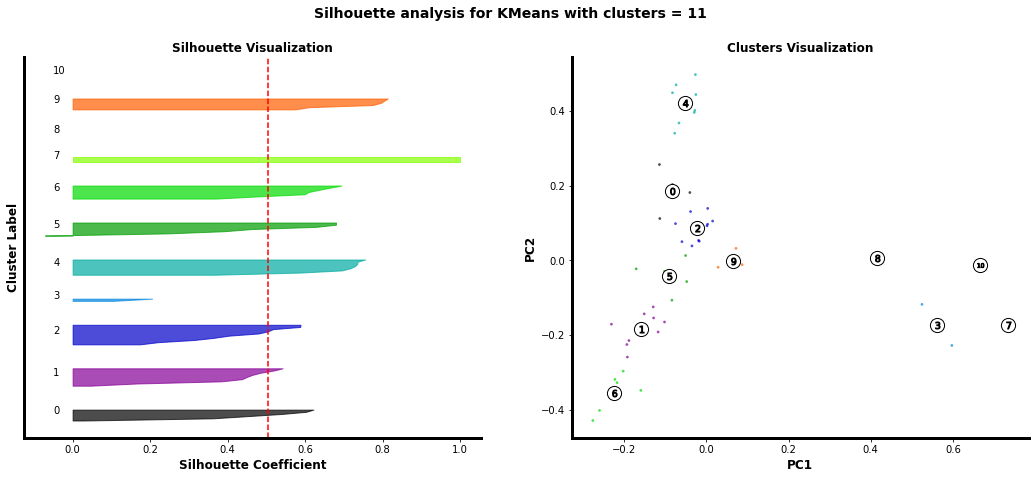

The average silhouette score = 0.4623767994101 for 14 clusters


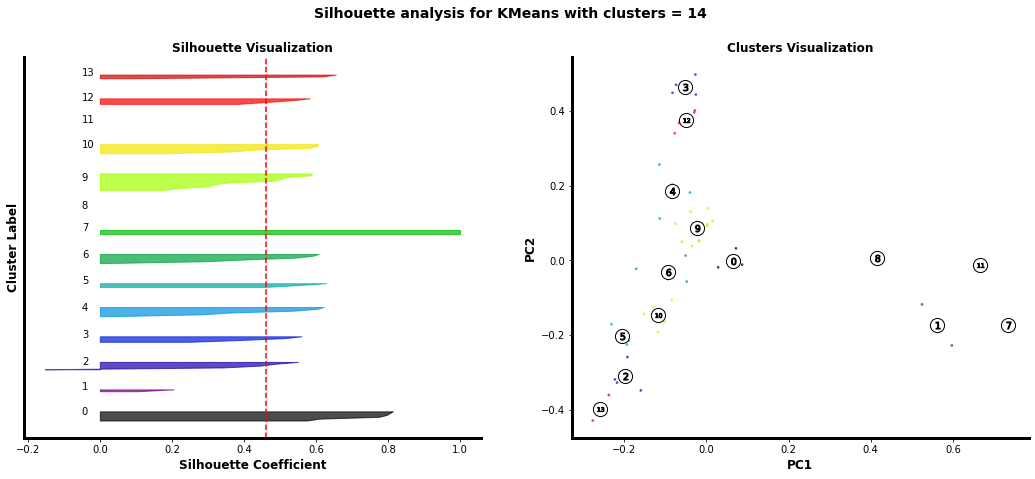

The average silhouette score = 0.4931464352125984 for 16 clusters


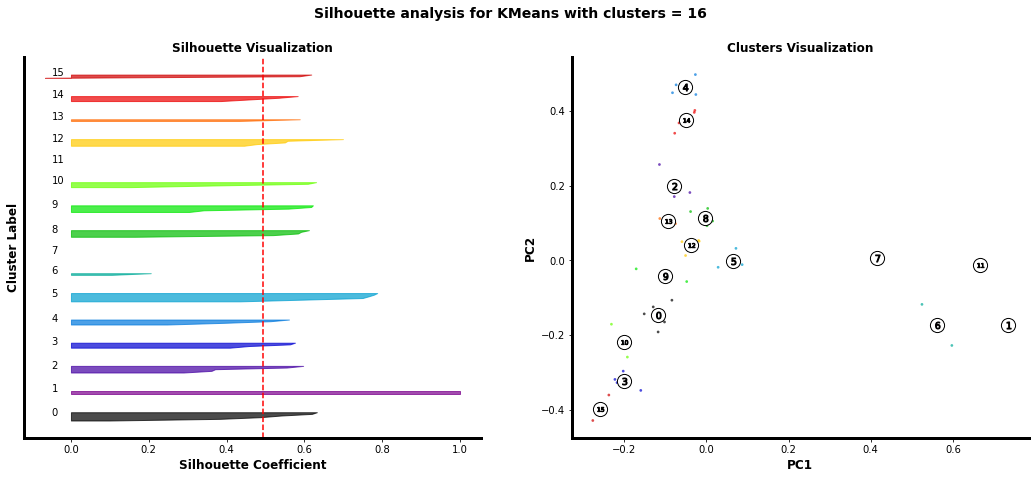

In [ ]:
pca_tfidf,PCA_components_tfidf=pca(X.toarray())
silhouette_vis(PCA_components_tfidf)

Since the model with cluster number of 16 gave the highest silhouette score, we will consider that for our prediction and recommender system.

**Train model with k-means, k=11**

In [ ]:
# 5. Train model with k-means
# true_k, derived from elbow method and confirmed from pluralsight's website
true_k = 11
# Running model with 15 different centroid initializations & maximum iterations are 500
model = KMeans(n_clusters=true_k, init='k-means++')
model.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=11, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

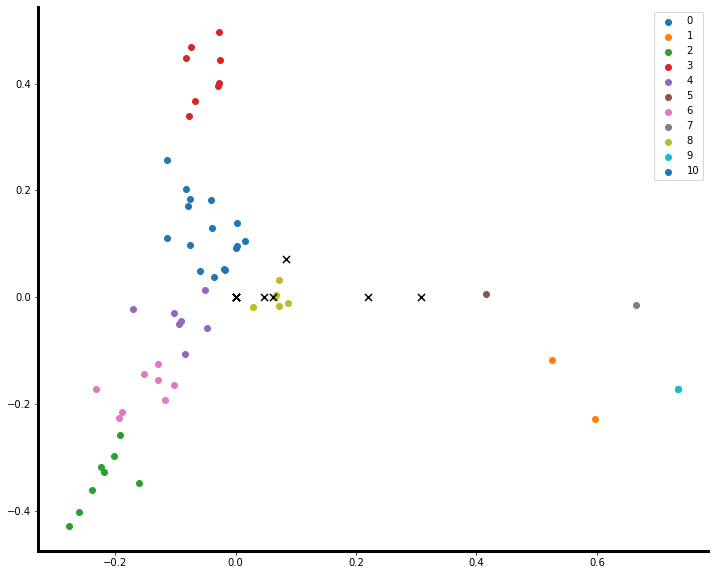

In [ ]:
# Visulize the clusters
from sklearn.decomposition import PCA
pca = PCA(2)
#Transform the data
df = pca.fit_transform(X.toarray())
#predict the labels of clusters.
km_model = KMeans(n_clusters=true_k, init='k-means++')
km_model.fit(df)
label = km_model.fit_predict(df)
#Getting unique labels
u_labels = np.unique(label)
#Getting the Centroids
centroids = model.cluster_centers_
u_labels = np.unique(label)
#plotting the results:
plt.figure(figsize=(12,10))
for i in u_labels:
    plt.scatter(df[label == i , 0] , df[label == i , 1] , label = i)
plt.scatter(centroids[:,0] , centroids[:,1] ,marker='x', s = 50, color = 'k')
plt.legend()
plt.show()

In [ ]:
# Preview top 15 words in each cluster, and accordingly different clusters can be assigned 
print("Top 15 words per cluster:\n")
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
for i in range(true_k):
    print("Cluster %d:" % i)
    lst=[]
    for ind in order_centroids[i, :15]:
      lst.append(terms[ind])
    print(lst,'\n')

Top 15 words per cluster:

Cluster 0:
['national', 'island', 'edward', 'flowerpot', 'parks', 'park', 'islands', 'elk', 'rim', 'pacific', 'hiking', 'trails', 'prince', 'ontario', 'alberta'] 

Cluster 1:
['water', 'bodies', 'alberta', 'lake', 'ontario', 'athabasca', 'lost', 'maligne', 'peyto', 'moraine', 'grassi', 'lakes', 'waterfalls', 'falls', 'icefields'] 

Cluster 2:
['points', 'landmarks', 'ontario', 'grotto', 'riverfront', 'windsor', 'niagara', 'war', 'military', 'architectural', 'tower', 'cn', 'canada', 'basilica', 'churches'] 

Cluster 3:
['museums', 'speciality', 'museum', 'canadian', 'history', 'bc', 'royal', 'western', 'saskatchewan', 'development', 'human', 'rights', 'manitoba', 'quebec', 'landmarks'] 

Cluster 4:
['historic', 'sites', 'village', 'heritage', 'fort', 'buildings', 'ontario', 'alberta', 'dundurn', 'castles', 'castle', 'parks', 'historical', 'park', 'amusement'] 

Cluster 5:
['mountains', 'whistler', 'bc', 'blackcomb', 'mountain', 'sports', 'complexes', 'ski', 's

In [ ]:
# The following text is used to test the model and check back if the results belong to the correct clusters
y = ['Parliament Hill, colloquially known as The Hill, is an area of Crown land on the southern banks of the Ottawa River in downtown Ottawa, Ontario, Canada. Its Gothic revival suite of buildings is the home of the Parliament of Canada and has architectural elements of national symbolic importance.',
     "Niagara Falls, Ontario, is a Canadian city at the famous waterfalls of the same name, linked with the U.S. by the Rainbow Bridge. Its site on the Niagara River's western shore overlooks the Horseshoe Falls, the cascades' most expansive section. Elevators take visitors to a lower, wetter vantage point behind the falls. A cliffside park features a promenade alongside 520-ft.-high Skylon Tower with an observation de"]
Y = vectorizer.transform(y)
prediction = model.predict(Y)
print(prediction) 

[9 6]


In [ ]:
# after checking the [3 13] in the Top 15 words per cluster: , the model clustered the given text to the correct clusters

**Prediction**

Decided Functionality: Takes location name (String) as input in the form of a function, returns a list of recommended locations up to 5 different attarctions.

In [ ]:
def cluster_predict(str_input):
    Y = vectorizer.transform(list(str_input))
    prediction = model.predict(Y)
    return prediction

In [ ]:
# create new column in dataframe which is combination of (location_name, location_type, provience) in existing data-frame
attractions_df['Input_Text'] = attractions_df.location_name.str.cat(" "+attractions_df.location_type.str.cat(" "+attractions_df.provience))
# Create new column for storing predicted categories from our trained model.
attractions_df['Predicted_Clusters'] = ""
# Cluster category for each attraction
attractions_df['Predicted_Clusters']=attractions_df.apply(lambda x: cluster_predict(attractions_df['Input_Text']), axis=0)

In [ ]:
attractions_df.sample(5)

,location_name,location_type,ratings,no. of rating,provience,user_id,Input_Text,Predicted_Clusters
location_id,,,,,,,,
17,Port Credit,Bodies of Water Neighbourhoods,4.5,953,ontario,2,Port Credit Bodies of Water Neighbourhoods o...,1
11,West Edmonton Mall,Shopping Malls,4.0,"4,198",alberta,4,West Edmonton Mall Shopping Malls alberta,1
44,Elk Island National Park,National Parks,2.5,600,alberta,4,Elk Island National Park National Parks alberta,0
49,Lynn Canyon Park,Parks,3.0,"2,174",BC,5,Lynn Canyon Park Parks BC,6
47,Sea to Sky Highway,Scenic Drives,4.5,"1,492",BC,5,Sea to Sky Highway Scenic Drives BC,6


**Recommend**



In [ ]:
def recommend(str_input):
    # Predict category of input string category
    temp_df = attractions_df.loc[attractions_df['location_name'] == str_input]
    temp_df['Input_Text'] = temp_df.location_name.str.cat(" "+temp_df.location_type.str.cat(" "+temp_df['provience']))
    str_input = list(temp_df['Input_Text'])
    
    prediction_inp = cluster_predict(str_input)
    prediction_inp = int(prediction_inp)
    
    temp_df = attractions_df.loc[attractions_df['Predicted_Clusters'] == prediction_inp]
    if len(temp_df)<5:
      temp_df = temp_df.sample(len(temp_df))
    else:
      temp_df = temp_df.sample(5)
    
    return list(temp_df['location_name'])

In [ ]:
queries = ['Mount Royal Park', 'Old Quebec', 
           'Niagara Falls Canada']

for query in queries:
    res = recommend(query)
    print("We have {} recommenations for [{}]:".format(len(res),query))
    print(res,'\n')

We have 5 recommenations for [Mount Royal Park]:
['Toronto Island Park', 'Kingston Waterfront', 'Mount Royal Park', "Ripley's Aquarium of Canada", 'Springbank Park'] 

We have 5 recommenations for [Old Quebec]:
['Old Quebec', 'Tremblant', 'Old Montreal', 'Le Petit Train du Nord Bike Path', 'The Calgary Zoo'] 

We have 5 recommenations for [Niagara Falls Canada]:
['Niagara Falls Canada', 'Canadian War Museum', 'Signal Hill', 'Windsor Riverfront', 'The Grotto'] 



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See

In [ ]:
# Limitation
# 1. the dataset is small.
# 2. there is no decription for each aatraction, it may enhance the clsutering

In [ ]:
# Save machine learning model
#filename = 'finalized_model.sav'
#pickle.dump(model, open(filename, 'wb'))

# For, loading the final model

# with open('finalized_model.sav', 'rb') as fid:
#     model = pickle.load(fid)


# References Links Used or Studied

# 1. https://www.analyticsvidhya.com/blog/2018/06/comprehensive-guide-recommendation-engine-python/
# 2. https://www.pluralsight.com/browse, For finding the original number of categories as '8' for all courses.
# 3. https://stats.stackexchange.com/questions/155880/text-mining-how-to-cluster-texts-e-g-news-articles-with-artificial-intellige  , A possible solution improvement from this thread. First try the svd approach[Currently, using similar to this approach only] and then doc2vec approach.
# 4. https://stackoverflow.com/questions/19197715/scikit-learn-k-means-elbow-criterion, Elbow method to find original value of 'k'.
# 5. https://pythonprogramminglanguage.com/kmeans-text-clustering/, Key resource in-use for clustering.
# 6. https://towardsdatascience.com/build-your-own-clustering-based-recommendation-engine-in-15-minutes-bdddd591d394

